In [3]:
import os
import matplotlib.pyplot as plt
import time
import pyvisa
import glob
import numpy as np
from pathlib import Path
import requests

print("All dependency libraries imported successfully!")

All dependency libraries imported successfully!


In [4]:
# Get current file directory and construct absolute paths
current_dir = Path.cwd()
tools_dir = current_dir / "../Tools"

awg_create_wave_path = tools_dir / "AWG_createWave.ipynb"
bvc_tools_path = tools_dir / "BVC_Tools.ipynb"

%run $awg_create_wave_path

generator = JupyterSignalGenerator()
analyzer = JupyterSignalAnalyzer(generator)

%run $bvc_tools_path

bvcTools = BVCTools()

print("Tool classes imported successfully!")

All dependency libraries imported successfully!
Signal parameter class definition completed!
Jupyter signal generator class definition completed!
Signal analyzer created successfully!
All dependency libraries imported successfully!
Jupyter signal generator class definition completed!
Tool classes imported successfully!


In [5]:
# Configure device parameters
device_ip = "127.0.0.1"

In [6]:
# Trigger parameters
trigger_source: str = "Internal" # """Internal/External""" 
in_trigger_repeat: int = 0xFFFFFFFF
in_trigger_cycle: float = 0.001

In [7]:
directory_path = current_dir / "seq_file"
file_pattern = os.path.join(directory_path, "*.bin")
bin_files = glob.glob(file_pattern)

if not bin_files:
    print(f"No .bin files found in directory {directory_path}")
print(f"Found {len(bin_files)} waveform files")

Found 7 waveform files


✓ Successfully read wave_chirp_180224_4000000000_0.8_100000000.0_0.0_0.0.bin: 180224 samples
✓ Successfully read wave_cose_180224_4000000000_0.8_100000000.0_0.0_0.0.bin: 180224 samples
✓ Successfully read wave_multi_tone_180224_4000000000_0.8_100000000.0_0.0_0.0.bin: 180224 samples
✓ Successfully read wave_pulse_180224_4000000000_0.8_100000000.0_0.0_0.0.bin: 180224 samples
✓ Successfully read wave_sine_180224_4000000000_0.8_100000000.0_0.0_0.0.bin: 180224 samples
✓ Successfully read wave_square_180224_4000000000_0.8_100000000.0_0.0_0.0.bin: 180224 samples
✓ Successfully read wave_triangle_180224_4000000000_0.8_100000000.0_0.0_0.0.bin: 180224 samples


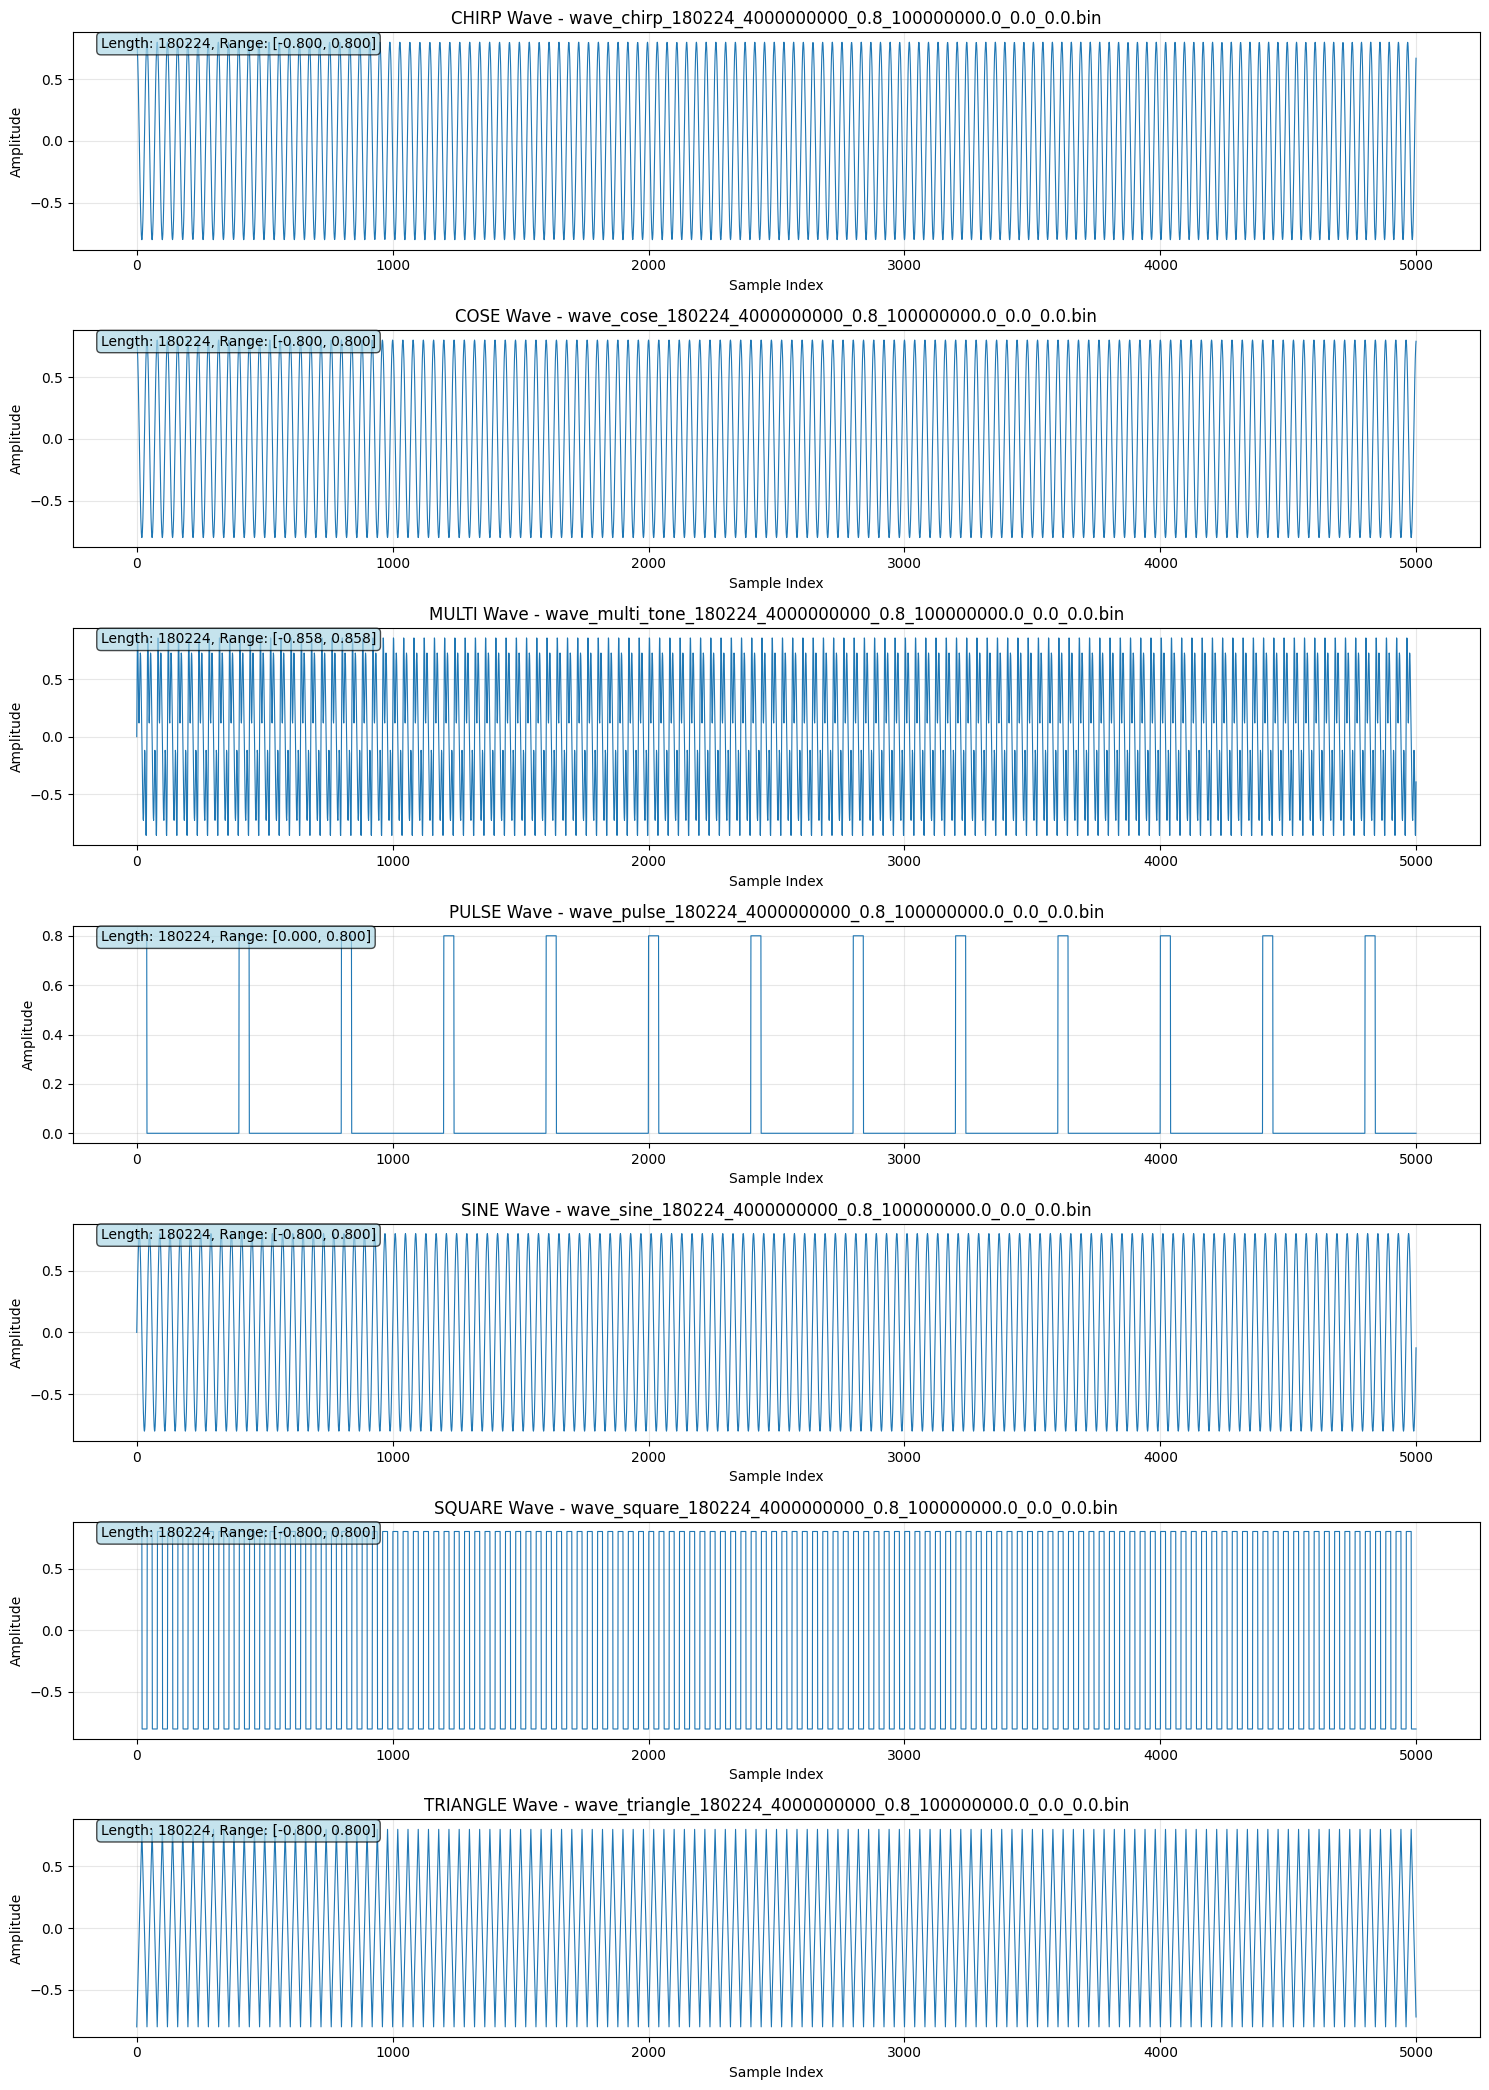

In [8]:
# Create a large figure to display all waveforms
fig, axes = plt.subplots(len(bin_files), 1, figsize=(15, 3*len(bin_files)))
if len(bin_files) == 1:
    axes = [axes] # Ensure axes is a list

for i, file_path in enumerate(sorted(bin_files)):
    try:
        # Read binary file
        with open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), dtype=np.float64)
        
        # Extract file name and waveform type
        file_name = os.path.basename(file_path)
        wave_type = file_name.split('_')[1]  # Extract waveform type
        
        # Plot waveform
        display_len = min(len(data), 5000)  # Display first 5000 samples
        time_axis = np.arange(display_len)
        
        axes[i].plot(time_axis, data[:display_len], linewidth=0.8)
        axes[i].set_title(f'{wave_type.upper()} Wave - {file_name}')
        axes[i].set_xlabel('Sample Index')
        axes[i].set_ylabel('Amplitude')
        axes[i].grid(True, alpha=0.3)
        
        # Add data information
        info_text = f'Length: {len(data)}, Range: [{np.min(data):.3f}, {np.max(data):.3f}]'
        axes[i].text(0.02, 0.98, info_text, transform=axes[i].transAxes, 
                    verticalalignment='top', bbox=dict(boxstyle='round', 
                    facecolor='lightblue', alpha=0.7))
        
        print(f"✓ Successfully read {file_name}: {len(data)} samples")
        
    except Exception as e:
        print(f"✗ Failed to read file {file_path}: {e}")
        continue

plt.tight_layout()
plt.show()

In [9]:
visa_resource = f'TCPIP::{device_ip}::5555::SOCKET'
        
rm = pyvisa.ResourceManager('@py')

session = rm.open_resource(visa_resource)  # open resource
session.write_termination = '\n'
session.read_termination = '\n'
session.timeout = 50000  # timeout unit: ms
scpi_query = session.query
scpi_write = session.write
scpi_read = session.read

In [10]:
model_info = {}
        
# Device name
device_name = scpi_query(':SYS:DEVice:NAMe? ').replace('\n', '').split(',')
# All module names on the device
module_names = scpi_query(':SYS:DEVice:MODUles?').replace('\n', '').split(',')
for module_name in module_names:
    module_dict = {}
    # Functions supported by this module
    funcs = scpi_query(f':SYS:DEVice:MODUles:FUNC? {module_name}').replace('\n', '').split(',')
    # Query all channels
    in_chnls = []
    out_chnls = []
    for func in funcs:
        if func == 'AWG':
            in_chnls = scpi_query(f':SYS:DEVice:MODUles:CHNLs:OUT? {module_name}').replace('\n', '').split(',')
        if func == 'Digitizer':
            out_chnls = scpi_query(f':SYS:DEVice:MODUles:CHNLs:IN? {module_name}').replace('\n', '').split(',')
    module_dict.setdefault("AWG", in_chnls)
    module_dict.setdefault("Digitizer", out_chnls)
    model_info.setdefault(module_name, module_dict)

print(f"device_name: {device_name}")
print(f"model_info: {model_info}")

device_name: ['TestDevice']
model_info: {'S0_M1210': {'AWG': [], 'Digitizer': []}, 'S0_M2301': {'AWG': [], 'Digitizer': []}, 'S2_M4901': {'AWG': ['CH1', 'CH2'], 'Digitizer': ['CH1', 'CH2']}}


In [11]:
# Module name
module_name = 'S2_M4901'
board_name = 'S0_M1210'
# Channel enable
channel_en = {"CH1": True,
              "CH2": True}

In [12]:
# Turn off DUC
scpi_query(f':AWG:SOURce:WAVE:InternalMultiple {module_name},1')

for key, value in channel_en.items():
    if value:
        scpi_query(f':AWG:OUTPut:DUC:EN {key},False')

In [13]:
# Configure sample rate
scpi_query(f':AWG:SOURce:DAC:SRATe {module_name},4')
bvcTools.sync(device_ip, module_name, board_name)

In [14]:
seg_list = []

for i, file_path in enumerate(bin_files):
    print(f"{i}. {os.path.basename(file_path)}")

    with open(file_path, 'rb') as f:
        file_len = os.path.getsize(file_path) # Total file length

        scpi_query(f':AWG:WAVList:ADDList {module_name},seg{i},{(file_len//8)},Double')

        files = {
            "file": f
        }
        response = requests.post(f'http://{device_ip}:8000/scpi', data={"scpi": f":AWG:WAVLIST:WAVeform:RTTRACE {module_name},seg{i},0,{file_len//8},\n"}, files=files)
        f.close()

        seg_list.append(f"seg{i}")


0. wave_sine_180224_4000000000_0.8_100000000.0_0.0_0.0.bin
1. wave_triangle_180224_4000000000_0.8_100000000.0_0.0_0.0.bin
2. wave_cose_180224_4000000000_0.8_100000000.0_0.0_0.0.bin
3. wave_square_180224_4000000000_0.8_100000000.0_0.0_0.0.bin
4. wave_pulse_180224_4000000000_0.8_100000000.0_0.0_0.0.bin
5. wave_chirp_180224_4000000000_0.8_100000000.0_0.0_0.0.bin
6. wave_multi_tone_180224_4000000000_0.8_100000000.0_0.0_0.0.bin


In [15]:
# Play once
NSWave_name = "sequence3"
# Create wave table
scpi_query(f':AWG:NSQC:ADD {NSWave_name}')

nsqc = """@nw.kernel
def program(wlist: dict[str, np.ndarray]):
"""
for i, seg in enumerate(seg_list):
    nsqc += f"    seg{i}: nw.ArbWave = nw.init_arbwave(wlist, '{seg}')\n"
for i, seg in enumerate(seg_list):
    nsqc += f"    nw.wait_for_trigger_with_source(1)  # Wait for trigger\n"
    nsqc += f"    nw.play_arb(seg{i})  # Play segment\n"
nsqc += "    return nw.Kernel()\n"
print(nsqc)

# Wait for external trigger playback
# nw.wait_for_trigger_with_source will modify logic trigger source
nswave_data = {
    "scpi": f":AWG:NSQC:UPload {NSWave_name},\n",
    "nsqc": nsqc
}
# Upload NSWave
response = requests.post(f'http://{device_ip}:8000/scpi', json=nswave_data)
# Compile
for key, value in channel_en.items():
    if value:
        scpi_query(f':AWG:NSQC:COMPile {key},{NSWave_name}')
# Deploy
scpi_query(f':AWG:WAVList:NSQC:COMPile:Send {module_name}')

@nw.kernel
def program(wlist: dict[str, np.ndarray]):
    seg0: nw.ArbWave = nw.init_arbwave(wlist, 'seg0')
    seg1: nw.ArbWave = nw.init_arbwave(wlist, 'seg1')
    seg2: nw.ArbWave = nw.init_arbwave(wlist, 'seg2')
    seg3: nw.ArbWave = nw.init_arbwave(wlist, 'seg3')
    seg4: nw.ArbWave = nw.init_arbwave(wlist, 'seg4')
    seg5: nw.ArbWave = nw.init_arbwave(wlist, 'seg5')
    seg6: nw.ArbWave = nw.init_arbwave(wlist, 'seg6')
    nw.wait_for_trigger_with_source(1)  # Wait for trigger
    nw.play_arb(seg0)  # Play segment
    nw.wait_for_trigger_with_source(1)  # Wait for trigger
    nw.play_arb(seg1)  # Play segment
    nw.wait_for_trigger_with_source(1)  # Wait for trigger
    nw.play_arb(seg2)  # Play segment
    nw.wait_for_trigger_with_source(1)  # Wait for trigger
    nw.play_arb(seg3)  # Play segment
    nw.wait_for_trigger_with_source(1)  # Wait for trigger
    nw.play_arb(seg4)  # Play segment
    nw.wait_for_trigger_with_source(1)  # Wait for trigger
    nw.play_arb(seg5)  #

''

In [16]:
# Delayed playbac
NSWave_name = "sequence4"
# Create wave table
scpi_query(f':AWG:NSQC:ADD {NSWave_name}')

nsqc = """@nw.kernel
def program(wlist: dict[str, np.ndarray]):
"""
for i, seg in enumerate(seg_list):
    nsqc += f"    seg{i}: nw.ArbWave = nw.init_arbwave(wlist, '{seg}')\n"
nsqc += "    while True:\n"
for i, seg in enumerate(seg_list):
    nsqc += f"        nw.wait_for_trigger_with_source(1)  # Wait for trigger\n"
    nsqc += f"        nw.wait({in_trigger_cycle/10})  # Delay one-tenth of the cycle\n"
    nsqc += f"        nw.play_arb(seg{i})  # Play segment\n"
nsqc += "    return nw.Kernel()\n"
print(nsqc)

# Wait for external trigger playback
# nw.wait_for_trigger_with_source will modify logic trigger source
nswave_data = {
    "scpi": f":AWG:NSQC:UPload {NSWave_name},\n",
    "nsqc": nsqc
}
# Upload NSWave
response = requests.post(f'http://{device_ip}:8000/scpi', json=nswave_data)
# Compile
for key, value in channel_en.items():
    if value:
        scpi_query(f':AWG:NSQC:COMPile {key},{NSWave_name}')
# Deploy
scpi_query(f':AWG:WAVList:NSQC:COMPile:Send {module_name}')

@nw.kernel
def program(wlist: dict[str, np.ndarray]):
    seg0: nw.ArbWave = nw.init_arbwave(wlist, 'seg0')
    seg1: nw.ArbWave = nw.init_arbwave(wlist, 'seg1')
    seg2: nw.ArbWave = nw.init_arbwave(wlist, 'seg2')
    seg3: nw.ArbWave = nw.init_arbwave(wlist, 'seg3')
    seg4: nw.ArbWave = nw.init_arbwave(wlist, 'seg4')
    seg5: nw.ArbWave = nw.init_arbwave(wlist, 'seg5')
    seg6: nw.ArbWave = nw.init_arbwave(wlist, 'seg6')
    while True:
        nw.wait_for_trigger_with_source(1)  # Wait for trigger
        nw.wait(0.0001)  # Delay one-tenth of the cycle
        nw.play_arb(seg0)  # Play segment
        nw.wait_for_trigger_with_source(1)  # Wait for trigger
        nw.wait(0.0001)  # Delay one-tenth of the cycle
        nw.play_arb(seg1)  # Play segment
        nw.wait_for_trigger_with_source(1)  # Wait for trigger
        nw.wait(0.0001)  # Delay one-tenth of the cycle
        nw.play_arb(seg2)  # Play segment
        nw.wait_for_trigger_with_source(1)  # Wait for trigger
      

''

In [17]:
# Loop playback
NSWave_name = "sequence5"
# Create wave table
scpi_query(f':AWG:NSQC:ADD {NSWave_name}')

nsqc = """@nw.kernel
def program(wlist: dict[str, np.ndarray]):
"""
for i, seg in enumerate(seg_list):
    nsqc += f"    seg{i}: nw.ArbWave = nw.init_arbwave(wlist, '{seg}')\n"
nsqc += "    i:nw.Reg\n"
for i, seg in enumerate(seg_list):
    nsqc += f"    for i in nw.loop(10):  # Loop iteration\n"
    nsqc += f"        nw.wait_for_trigger_with_source(1)  # Wait for trigger\n"
    nsqc += f"        nw.play_arb(seg{i})  # Play segment\n"
nsqc += "    return nw.Kernel()\n"
print(nsqc)

# Wait for external trigger playback
# nw.wait_for_trigger_with_source will modify logic trigger source
nswave_data = {
    "scpi": f":AWG:NSQC:UPload {NSWave_name},\n",
    "nsqc": nsqc
}
# Upload NSWave
response = requests.post(f'http://{device_ip}:8000/scpi', json=nswave_data)
# Compile
for key, value in channel_en.items():
    if value:
        scpi_query(f':AWG:NSQC:COMPile {key},{NSWave_name}')
# Deploy
scpi_query(f':AWG:WAVList:NSQC:COMPile:Send {module_name}')

@nw.kernel
def program(wlist: dict[str, np.ndarray]):
    seg0: nw.ArbWave = nw.init_arbwave(wlist, 'seg0')
    seg1: nw.ArbWave = nw.init_arbwave(wlist, 'seg1')
    seg2: nw.ArbWave = nw.init_arbwave(wlist, 'seg2')
    seg3: nw.ArbWave = nw.init_arbwave(wlist, 'seg3')
    seg4: nw.ArbWave = nw.init_arbwave(wlist, 'seg4')
    seg5: nw.ArbWave = nw.init_arbwave(wlist, 'seg5')
    seg6: nw.ArbWave = nw.init_arbwave(wlist, 'seg6')
    for i in nw.loop(10):  # Loop iteration
        nw.wait_for_trigger_with_source(1)  # Wait for trigger
        nw.play_arb(seg0)  # Play segment
    for i in nw.loop(10):  # Loop iteration
        nw.wait_for_trigger_with_source(1)  # Wait for trigger
        nw.play_arb(seg1)  # Play segment
    for i in nw.loop(10):  # Loop iteration
        nw.wait_for_trigger_with_source(1)  # Wait for trigger
        nw.play_arb(seg2)  # Play segment
    for i in nw.loop(10):  # Loop iteration
        nw.wait_for_trigger_with_source(1)  # Wait for trigger
        nw.pla

''

In [18]:
# Sub-loop
NSWave_name = "sequence6"
# Create wave table
scpi_query(f':AWG:NSQC:ADD {NSWave_name}')

nsqc = """@nw.kernel
def program(wlist: dict[str, np.ndarray]):
"""
for i, seg in enumerate(seg_list):
    nsqc += f"    seg{i}: nw.ArbWave = nw.init_arbwave(wlist, '{seg}')\n"
nsqc += "    i:nw.Reg\n"
nsqc += "    while True:\n"
for i, seg in enumerate(seg_list):
    nsqc += f"        for i in nw.loop(10):  # Loop iteration\n"
    nsqc += f"            nw.wait_for_trigger_with_source(1)  # Wait for trigger\n"
    nsqc += f"            nw.play_arb(seg{i})  # Play segment\n"
nsqc += "    return nw.Kernel()\n"
print(nsqc)

# Wait for external trigger playback
# nw.wait_for_trigger_with_source will modify logic trigger source
nswave_data = {
    "scpi": f":AWG:NSQC:UPload {NSWave_name},\n",
    "nsqc":nsqc
}
# Upload NSWave
response = requests.post(f'http://{device_ip}:8000/scpi', json=nswave_data)
# Compile
for key, value in channel_en.items():
    if value:
        scpi_query(f':AWG:NSQC:COMPile {key},{NSWave_name}')
# Deploy
scpi_query(f':AWG:WAVList:NSQC:COMPile:Send {module_name}')

@nw.kernel
def program(wlist: dict[str, np.ndarray]):
    seg0: nw.ArbWave = nw.init_arbwave(wlist, 'seg0')
    seg1: nw.ArbWave = nw.init_arbwave(wlist, 'seg1')
    seg2: nw.ArbWave = nw.init_arbwave(wlist, 'seg2')
    seg3: nw.ArbWave = nw.init_arbwave(wlist, 'seg3')
    seg4: nw.ArbWave = nw.init_arbwave(wlist, 'seg4')
    seg5: nw.ArbWave = nw.init_arbwave(wlist, 'seg5')
    seg6: nw.ArbWave = nw.init_arbwave(wlist, 'seg6')
    while True:
        for i in nw.loop(10):  # Loop iteration
            nw.wait_for_trigger_with_source(1)  # Wait for trigger
            nw.play_arb(seg0)  # Play segment
        for i in nw.loop(10):  # Loop iteration
            nw.wait_for_trigger_with_source(1)  # Wait for trigger
            nw.play_arb(seg1)  # Play segment
        for i in nw.loop(10):  # Loop iteration
            nw.wait_for_trigger_with_source(1)  # Wait for trigger
            nw.play_arb(seg2)  # Play segment
        for i in nw.loop(10):  # Loop iteration
            nw.wait_f

''

In [19]:
# Trigger configuration
if trigger_source == "Internal":
    scpi_query(f':SAT:TRIGger:SOURce {board_name},Internal')
    scpi_query(f':SAT:TRIGger:INTernal:REPeat {board_name},{in_trigger_repeat}')
    scpi_query(f':SAT:TRIGger:INTernal:CYCle {board_name},{in_trigger_cycle}')

    scpi_query(f':AWG:TRIGger:SOURce {module_name},PXISTARTrig')
    scpi_query(f':AWG:TRIGger:INTernal:REPeat {module_name},{in_trigger_repeat}')
    scpi_query(f':AWG:TRIGger:INTernal:CYCle {module_name},{in_trigger_cycle}')
elif trigger_source == "External":
    scpi_query(f':SAT:TRIGger:SOURce {board_name},External')
    scpi_query(f':AWG:TRIGger:SOURce {module_name},PXISTARTrig')
else:
    print(f"Error: {trigger_source} does not exist")

In [20]:
# Configure enable
for key, value in channel_en.items():
    rate = scpi_query(f':AWG:OUTPut:EN {key},{value}')
scpi_query(f':SYS:Control:RUN {module_name}')
scpi_query(f':SAT:TRIGger:INTernal:Run {board_name}')

''

In [21]:
time.sleep(10)

In [22]:
scpi_query(f':SAT:TRIGger:INTernal:Stop {board_name}')
scpi_query(f':SYS:Control:STOP {module_name}')

''